# Compute projections
Best options is to run `iss project-round` command after each acquisition:

`DATAPATH=BARseq/FIAA48.1b/chambre_03_random`

`iss project-round -p $DATAPATH -n $PREFIX`

where `$DATAPATH` is the path to the data relative to raw data root and `$PREFIX` is the file name prefix and directory name of the round, e.g. `genes_round_1_1`.

This will also start a "plot_overview" job for each round, which will generate a plot of the projected data.
Use this to select a few tiles to use for registration and change `ops.yml` to add these tiles.

## Import requirements

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import iss_preprocess as iss
import numpy as np
import matplotlib.pyplot as plt
from flexiznam.config import PARAMETERS
from pathlib import Path
from itertools import cycle
from matplotlib.animation import FuncAnimation

## Set path and load options

In [5]:
data_path = "becalia_rabies_barseq/BRYC65.1d/chamber_13/"
data_path = "BARseq/FIAA48.1b/chambre_03_random"
data_path = "becalia_rabies_barseq/BRAC8501.6a/chamber_07/"
processed_path = Path(PARAMETERS["data_root"]["processed"])
ops = iss.io.load_ops(data_path)
metadata = iss.io.load_metadata(data_path)

# Illumination correction

Illumination correction is done in two steps: 

- Average each acquisition folder:

This can be done with: `iss create-all-single-averages -p $DATAPATH`

- Average all acquisition averages for each "round" type of data

This can be done with: `iss create-grand-averages -p $DATAPATH`

One can also generate some summary diagnostic plot that will be saved in the `figures`
subfolder of `data_path`

In [ ]:
# Generate diagnostic plot
from iss_preprocess.pipeline import diagnostics

# it takes about 2 minutes to run and save all images
diagnostics.check_illumination_correction(
    data_path, grand_averages=("genes_round",), verbose=False
)

In [ ]:
prefix = "genes_round"
processed_path = iss.io.get_processed_path(data_path)
target_folder = processed_path / "figures" / "registration"

target_folder.mkdir(exist_ok=True, parents=True)

ops = iss.io.load_ops(data_path)
nrounds = ops[f"{prefix}s"]

# get stack registered between channel and rounds
reg_stack, bad_pixels = iss.pipeline.sequencing.load_and_register_sequencing_tile(
    data_path,
    filter_r=False,
    correct_channels=False,
    correct_illumination=False,
    corrected_shifts="reference",
    tile_coors=ops["ref_tile"],
    suffix=ops[f"{prefix.split('_')[0]}_projection"],
    prefix=prefix,
    nrounds=nrounds,
    specific_rounds=None,
)

In [ ]:
iss.pipeline.vis.plot_sequencing_rounds(reg_stack, vmax=3000)

# Normalise channels and rounds

Will try to normalise rolonie brightness across rounds and channels. 

`iss setup-channel-correction -p $DATAPATH`

counting pixel values for roi 5, tile 3, 3
counting pixel values for roi 5, tile 4, 3
counting pixel values for roi 5, tile 4, 4
counting pixel values for roi 6, tile 5, 3
counting pixel values for roi 4, tile 3, 3
counting pixel values for roi 4, tile 4, 3
counting pixel values for roi 3, tile 4, 3


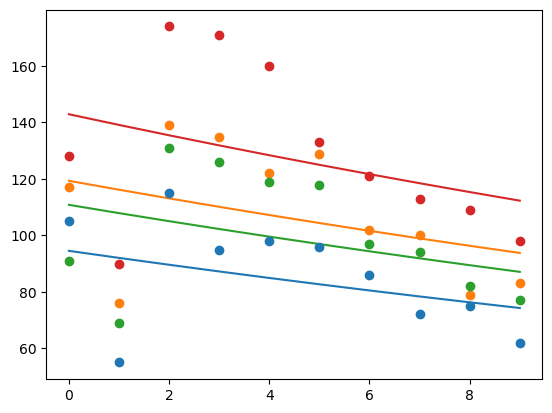

In [6]:
# You can redo it here to get a plot:
pixel_dist, norm_factors, norm_factors_raw = iss.pipeline.estimate_channel_correction(
    data_path,
    prefix="barcode_round",
    nrounds=ops["barcode_rounds"],
    fit_norm_factors=ops["fit_channel_correction"],
)
plt.figure()
plt.plot(norm_factors.T)
plt.gca().set_prop_cycle(None)
plt.plot(norm_factors_raw.T, "o")

# Register sequencing rounds

It has 3 steps:

- Register reference tile
- Register all tiles using reference tile initial estimate
- Correct shifts

## Register reference tile

It can be done simply with:

`iss register-ref-tile -p $DATAPATH`

Below is a verbose version for debugging:

In [ ]:
# Load the ref tile data
prefix = "genes_round"
ops = iss.io.load.load_ops(data_path)
nrounds = ops[prefix + "s"]
projection = ops[f"{prefix.split('_')[0].lower()}_projection"]
stack = iss.pipeline.sequencing.load_sequencing_rounds(
    data_path, ops["ref_tile"], prefix=prefix, suffix=projection, nrounds=nrounds
)
ori_stack = stack.copy()
from scipy.ndimage import median_filter

if ops["reg_median_filter"]:
    msize = ops["reg_median_filter"]
    msize = 5
    print(f"Filtering with median filter of size {msize}")
    assert isinstance(msize, int), "reg_median_filter must be an integer"
    for ch in range(stack.shape[2]):
        for r in range(stack.shape[3]):
            stack[:, :, ch, r] = median_filter(stack[:, :, ch, r], size=msize)

In [ ]:
vmax = np.percentile(stack[:, :, 0, 0], 99.9)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(ori_stack[:, :, 0, 0], cmap="gray", vmax=vmax)
ax.set_title("Original")
ax.axis("off")
ax = fig.add_subplot(1, 3, 2)
ax.imshow(stack[:, :, 0, 0], cmap="gray", vmax=vmax)
ax.set_title("Median filtered")
ax.axis("off")
ax = fig.add_subplot(1, 3, 3)
diff = stack[:, :, 0, 0].astype(float) - ori_stack[:, :, 0, 0].astype(float)
im = ax.imshow(diff, cmap="RdBu_r", vmin=-vmax / 10, vmax=vmax / 10)
plt.colorbar(mappable=im, ax=ax)
ax.set_title("Difference")
ax.axis("off")
for x in fig.axes[:-1]:
    x.set_xlim(1000, 1500)
    x.set_ylim(1500, 1000)

In [ ]:
from pathlib import Path

iss.pipeline.diagnostics.check_ref_tile_registration(
    data_path,
    prefix="genes_round",
    use_slurm=True,
    slurm_folder=Path.home() / "slurm_logs",
)

In [ ]:
if False:
    # first call is:
    (
        angles_within_channels,
        shifts_within_channels,
        scales_between_channels,
        angles_between_channels,
        shifts_between_channels,
    ) = iss.pipeline.register_channels_and_rounds(
        stack, ref_ch=ops["ref_ch"], ref_round=ops["ref_round"]
    )

In [ ]:
if False:
    # which calls
    # first register images across rounds within each channel
    angles_within_channels, shifts_within_channels = iss.reg.align_within_channels(
        stack, upsample=False, ref_round=ops["ref_round"]
    )
# That is already bad:
o = """
optimizing angles and shifts for channel 0
angle: 0.0, shift: [0.0, 0.0]
angle: -0.0857142857142858, shift: [2. 0.]
angle: 0.05714285714285708, shift: [-1635.  -370.]
angle: -0.0857142857142858, shift: [2. 0.]
angle: 0.08571428571428566, shift: [-171.  -12.]
angle: -0.0857142857142858, shift: [2. 0.]
angle: 0.05714285714285708, shift: [-1635.  -370.]
optimizing angles and shifts for channel 1
angle: 0.0, shift: [0.0, 0.0]
"""

In [ ]:
upsample = False
ref_round = ops["ref_round"]
angle_range = 1.0
niter = 3
nangles = 15
min_shift = 2
nchannels, nrounds = stack.shape[2:]
angles_channels = []
shifts_channels = []
ref_ch = 0
print(f"optimizing angles and shifts for channel {ref_ch}", flush=True)
angles = []
shifts = []
iround = 1
if True:
    angle, shift = iss.reg.rounds_and_channels.estimate_rotation_translation(
        stack[:, :, ref_ch, ref_round],
        stack[:, :, ref_ch, iround],
        angle_range=angle_range,
        niter=niter,
        nangles=nangles,
        min_shift=min_shift,
        upsample=upsample,
    )
    print(f"angle: {angle}, shift: {shift}")

In [ ]:
reference = stack[:, :, ref_ch, ref_round]
reference /= reference.mean()
target = stack[:, :, ref_ch, iround]
target /= target.mean()
import scipy

best_angle = 0
reference_fft = scipy.fft.fft2(reference)
angles = np.linspace(-angle_range, angle_range, nangles) + best_angle
max_cc = np.empty(angles.shape)
shifts = np.empty((nangles, 2))
best_angle, max_cc, all_cc = iss.reg.rounds_and_channels.estimate_rotation_angle(
    reference_fft, target, angle_range, best_angle, nangles, min_shift=0, debug=True
)

In [ ]:
im = np.stack([reference, target, reference], axis=2)
best_cc = np.unravel_index(all_cc.argmax(), all_cc.shape)
best_cc

In [ ]:
fig = plt.figure(figsize=(15, 10))
vmax = np.percentile(reference, 99.9)
ax = fig.add_subplot(231)
ax.set_title("reference")
ax.imshow(reference, vmax=vmax)
ax = fig.add_subplot(232)
ax.set_title("round 2")
ax.imshow(target, vmax=vmax)
ax = fig.add_subplot(233)
ax.set_title("overlay")
ax.imshow(
    iss.vis.to_rgb(
        im, colors=[[1, 0, 0], [0, 1, 0], [0, 0, 1]], vmax=[vmax, vmax, vmax]
    )
)

# plot the CC
vmax = np.percentile(all_cc, 99.999)
ax = fig.add_subplot(234)
ax.set_title("CC, best angle")
ax.imshow(all_cc[best_cc[0]], vmax=vmax)
m = np.unravel_index(all_cc[best_cc[0]].argmax(), all_cc[0].shape)
ax.scatter(m[1], m[0], fc="none", edgecolors="r")
ax = fig.add_subplot(235)

ax.imshow(all_cc[best_cc[0]], vmax=vmax)
middle = all_cc[best_cc[0]].shape[0] // 2
ax.scatter(m[1], m[0], fc="none", edgecolors="r")
ax.set_xlim(middle - 40, middle + 40)
ax.set_ylim(middle + 40, middle - 40)

ax = fig.add_subplot(236)
ax.imshow(all_cc[best_cc[0]])
ax.scatter(m[1], m[0], fc="none", edgecolors="r")
ax.set_xlim(best_cc[2] - 40, best_cc[2] + 40)
ax.set_ylim(best_cc[1] + 40, best_cc[1] - 40)

In [ ]:
# Try with mediian filtered version
reference = scipy.ndimage.median_filter(stack[:, :, ref_ch, ref_round], size=2)
target = scipy.ndimage.median_filter(stack[:, :, ref_ch, iround], size=2)
import scipy

best_angle = 0
reference_fft = scipy.fft.fft2(reference)
angles = np.linspace(-angle_range, angle_range, nangles) + best_angle
max_cc = np.empty(angles.shape)
shifts = np.empty((nangles, 2))
best_angle, max_cc, all_cc = iss.reg.rounds_and_channels.estimate_rotation_angle(
    reference_fft, target, angle_range, best_angle, nangles, min_shift=0, debug=True
)

In [ ]:
im = np.stack([reference, target, reference], axis=2)
best_cc = np.unravel_index(all_cc.argmax(), all_cc.shape)
best_cc

In [ ]:
fig = plt.figure(figsize=(15, 10))
vmax = np.percentile(stack[:, :, ref_ch, iround], 99.9)
ax = fig.add_subplot(231)
ax.set_title("reference")
ax.imshow(reference, vmax=vmax)
ax = fig.add_subplot(232)
ax.set_title("round 2")
ax.imshow(stack[:, :, ref_ch, iround], vmax=vmax)
ax = fig.add_subplot(233)
ax.set_title("overlay")
ax.imshow(
    iss.vis.to_rgb(im, colors=[[1, 0, 0], [0, 1, 0], [0, 0, 1]], vmax=[400, 400, 400])
)

# plot the CC
vmax = np.percentile(all_cc, 99.999)
ax = fig.add_subplot(234)
ax.set_title("CC, best angle")
ax.imshow(all_cc[best_cc[0]], vmax=vmax)
m = np.unravel_index(all_cc[best_cc[0]].argmax(), all_cc[0].shape)
ax.scatter(m[1], m[0], fc="none", edgecolors="r")
ax = fig.add_subplot(235)

ax.imshow(all_cc[best_cc[0]], vmax=vmax)
middle = all_cc[best_cc[0]].shape[0] // 2
ax.scatter(m[1], m[0], fc="none", edgecolors="r")
ax.set_xlim(middle - 40, middle + 40)
ax.set_ylim(middle + 40, middle - 40)

ax = fig.add_subplot(236)
ax.imshow(all_cc[best_cc[0]])
ax.scatter(m[1], m[0], fc="none", edgecolors="r")
ax.set_xlim(middle - 40, middle + 40)
ax.set_ylim(middle + 40, middle - 40)

Start a registration jobs for the reference tile for genes and barcodes:

`iss register-ref-tile -p $DATAPATH -n genes_round`

`iss register-ref-tile -p $DATAPATH -n barcode_round`

where `$DATAPATH` is the path to the data relative to raw data root

Next, estimate shifts for individual tiles:

`iss estimate-shifts -p $DATAPATH -n barcode_round`

`iss estimate-shifts -p $DATAPATH -n genes_round`

Finally, calculate robust regression corrected shifts:

`iss correct-shifts -p $DATAPATH -n barcode_round`

`iss correct-shifts -p $DATAPATH -n genes_round`

# Prepare parameters for OMP and barcode calling

`iss setup-omp -p $DATAPATH`

`iss setup-barcodes -p $DATAPATH`

# Check registration

In [ ]:
iss.call.BASES

In [ ]:
stack, bad_pixels = iss.pipeline.load_and_register_sequencing_tile(
    data_path,
    ops["ref_tile"],
    filter_r=False,
    prefix="genes_round",
    suffix=ops["genes_projection"],
    nrounds=ops["genes_rounds"],
    correct_channels=True,
    corrected_shifts="reference",
    correct_illumination=True,
)
stack = stack[:, :, np.argsort(ops["camera_order"]), :]
nrounds = stack.shape[3]
channel_colors = [[1, 0, 0], [0, 1, 0], [0, 1, 1], [1, 0, 1]]


def round_image(iround):
    data = stack[501:1000, 1501:2000, :, iround]
    return iss.vis.to_rgb(
        data,
        channel_colors,
        vmin=np.array([0, 0, 0, 0]),
        vmax=np.percentile(data, 99.99, axis=(0, 1)),
    )


fig = plt.figure(figsize=(10, 8))
for iround in range(nrounds):
    plt.subplot(3, 4, iround + 1)
    plt.imshow(round_image(iround))
    plt.axis("off")
plt.tight_layout()

In [ ]:
iss.call.BASES

In [ ]:
stack, bad_pixels = iss.pipeline.load_and_register_sequencing_tile(
    data_path,
    (2, 4, 9),
    filter_r=ops["filter_r"],
    prefix="barcode_round",
    suffix=ops["barcode_projection"],
    nrounds=ops["barcode_rounds"],
    correct_channels=True,
    corrected_shifts=True,
    correct_illumination=True,
)
stack = stack[:, :, np.argsort(ops["camera_order"]), :]
nrounds = stack.shape[3]
channel_colors = [[1, 0, 0], [0, 1, 0], [0, 1, 1], [1, 0, 1]]


def round_image(iround):
    vmax = 3
    return iss.vis.to_rgb(
        stack[501:1000, 1501:2000, :, iround],
        channel_colors,
        vmin=np.array([0, 0, 0, 0]),
        vmax=np.array([1, 1, 1, 1]) * vmax,
    )


fig = plt.figure(figsize=(10, 8))
for iround in range(nrounds):
    plt.subplot(3, 4, iround + 1)
    plt.imshow(round_image(iround))
    plt.axis("off")
plt.tight_layout()

In [ ]:
%matplotlib ipympl
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(round_image(0))


def animate(frame_num):
    im.set_data(round_image(frame_num))
    ax1.set_title(f"round {frame_num}")
    return im


anim = FuncAnimation(fig, animate, frames=nrounds, interval=2000)
plt.show()

# Re-compute average spot image

Run OMP on the reference tile and detect spots to generate a new spot sign image.

`iss spot-image -p becalia_rabies_barseq/BRYC65.1d/chamber_13/`

# Check barcode threshold

In [ ]:
stack, bad_pixels = iss.pipeline.load_and_register_tile(
    data_path,
    ops["ref_tile"],
    filter_r=ops["filter_r"],
    prefix="barcode_round",
    suffix=ops["barcode_projection"],
    nrounds=10,
    correct_channels=ops["barcode_correct_channels"],
    corrected_shifts=True,
    correct_illumination=True,
)
spots = iss.segment.detect_spots(np.mean(stack, axis=(2, 3)), threshold=0.1)
plt.figure(figsize=(10, 10))
plt.imshow(np.mean(stack, axis=(2, 3)), cmap="bwr", vmin=-0.1, vmax=0.1)
plt.plot(spots["x"], spots["y"], ".k", markersize=0.5)

# Run OMP
Run `iss extract` to start Slurm jobs to run OMP on each tile:

`iss extract -p becalia_rabies_barseq/BRYC65.1d/chamber_13/`

# Run basecalling

`iss basecall -p becalia_rabies_barseq/BRYC65.1d/chamber_13/`


# Register to reference

To register barcodes to the reference `genes_round_1_1`, we estimate the shift and 
angle at each tile:

`iss register-to-reference -p becalia_rabies_barseq/BRYC65.1d/chamber_13 -g barcode_round`

Then the shifts estimates are corrected using robust regression:

`iss correct-ref-shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13 -g barcode_round`

And plot diagnostic plot if wanted:

In [ ]:
from iss_preprocess.pipeline.diagnostics import reg_to_ref_estimation

reg_to_ref_estimation(data_path, prefix="barcode_round")


Then merge barcodes across tiles and align to gene rounds:

`iss align-spots -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -s barcode_round -g barcode_round_1_1 -r genes_round_1_1`


# Merge OMP output

In [ ]:
shift_right, shift_down, tile_shape = iss.pipeline.register_adjacent_tiles(
    data_path, ref_coors=ops["ref_tile"], prefix="genes_round_1_1"
)
for iroi in range(8):
    spots = iss.pipeline.merge_roi_spots(
        data_path, shift_right, shift_down, tile_shape, iroi=iroi + 1
    )
    save_path = (
        Path(PARAMETERS["data_root"]["processed"])
        / data_path
        / f"gene_spots_{iroi+1}.pkl"
    )
    spots.to_pickle(save_path)

# Plot some barcodes and genes

In [ ]:
import pandas as pd

all_spots = []
genes_spots = []
for i, roi in enumerate(ops["use_rois"]):
    save_path = processed_path / data_path / f"barcode_round_spots_{roi}.pkl"
    these_spots = pd.read_pickle(save_path)
    these_spots["roi"] = roi
    all_spots.append(these_spots)
    these_spots = pd.read_pickle(processed_path / data_path / f"gene_spots_{roi}.pkl")
    these_spots["roi"] = roi
    genes_spots.append(these_spots)

spots = pd.concat(all_spots, ignore_index=True)
genes_spots = pd.concat(genes_spots, ignore_index=True)

In [ ]:
spots = iss.call.correct_barcode_sequences(
    spots[spots["dot_product_score"] > 0.25], max_edit_distance=1
)

from itertools import cycle
from matplotlib import rcParams

plt.style.use("default")

fig = plt.figure(figsize=(20, 40), dpi=300)
fig.patch.set_facecolor("black")

sequence_counts = spots["corrected_bases"].value_counts()
xmax = spots["x"].max()
ymax = spots["y"].max()
genes = genes_spots["gene"].unique()
prop_cycle = plt.rcParams["axes.prop_cycle"]
rois = genes_spots["roi"].unique()
genes_to_plot = [
    "Crym",
    "Ctgf",
    "Igfbp4",
    "Lamp5",
    "Lypd1",
    "Npy",
    "Rgs4",
    "Necab1",
    "Cck",
    "Myl4",
    "Th",
]
for iseq, seq in enumerate(sequence_counts.index[:8]):
    plt.subplot(10, 1, iseq + 1)
    plt.title(seq, color="white")
    plt.gca().set_aspect("equal", "box")
    plt.gca().set_facecolor("black")
    colors = cycle(
        [
            "deepskyblue",
            "darkorange",
            "forestgreen",
            "royalblue",
            "magenta",
            "coral",
            "gold",
            "mediumorchid",
            "red",
            "lawngreen",
        ]
    )

    # for gene in genes_to_plot:
    #     c = next(colors)
    #     alpha = np.min([ 1e5 / np.sum(genes_spots['gene']==gene), 0.2 ])
    #     for iroi, roi in enumerate(rois):
    #         plt.plot(
    #             genes_spots[(genes_spots['gene']==gene) & (genes_spots['roi']==roi)]['x'] + iroi*60000,
    #             genes_spots[(genes_spots['gene']==gene) & (genes_spots['roi']==roi)]['y'],
    #             ',',
    #             c=c,
    #             alpha=alpha,
    #         )
    for iroi, roi in enumerate(rois):
        this_barcode = spots[(spots["corrected_bases"] == seq) & (spots["roi"] == roi)]
        plt.plot(
            this_barcode["x"] + iroi * 60000,
            this_barcode["y"],
            "s",
            markersize=0.2,
            c="white",
        )
    plt.axis("off")
    plt.gca().invert_yaxis()
    plt.tight_layout()

# Generate an overview image and segment cells

Test segmentation parameters:


In [ ]:
roi = 5
(
    stitched_stack_dapi,
    stitched_stack_genes,
    angle,
    shift,
) = iss.pipeline.stitch_and_register(
    data_path, "genes_round_1_1", "barcode_round_10_1", roi=roi, downsample=5
)

In [ ]:
masks = np.load(processed_path / data_path / "masks_1.npy")
im = np.stack(
    [
        stitched_stack_genes[3000:10000, 12000:20000],
        stitched_stack_dapi[3000:10000, 12000:20000],
        masks[3000:10000, 12000:20000] > 0,
    ],
    axis=2,
)
shift_right, shift_down, tile_shape = iss.pipeline.register_adjacent_tiles(
    data_path, ref_coors=ops["ref_tile"], prefix="genes_round_1_1"
)
spots = iss.pipeline.merge_roi_spots(
    data_path, shift_right, shift_down, tile_shape, iroi=roi, prefix="genes_round"
)
plt.figure(figsize=(50, 50))
plt.imshow(
    iss.vis.to_rgb(
        im,
        colors=[[1, 0, 0], [0, 0, 1], [0, 1, 0]],
        vmax=[400, 200, 1],
        vmin=np.array([30, 0, 0]),
    )
)
plt.plot(spots["x"] - 12000, spots["y"] - 3000, ".r", alpha=1, markersize=0.5)
plt.xlim([0, 8000])
plt.ylim([7000, 0])
plt.axis("off")

In [ ]:
from cellpose.models import CellposeModel
from cellpose.plot import mask_rgb

model = CellposeModel(gpu=True, model_type="cyto", net_avg=False)
masks, flows, styles = model.eval(
    stitched_stack_dapi[11000:12000, 5000:6000],
    rescale=0.55,
    channels=[0, 0],
    flow_threshold=0.4,
    tile=True,
)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(stitched_stack_dapi[11000:12000, 5000:6000], vmax=1000)
plt.subplot(1, 2, 2)
plt.imshow(mask_rgb(masks))

# Run batch segmentation:

`iss segment-all -p $DATAPATH -n $PREFIX`

# Align hybridisation rounds
To run all hybridisation rounds listed in metadata:

`iss estimate-hyb-shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/`

`iss correct_hyb_shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/`

To run a specific round, e.g. anchor round:

`iss estimate-hyb-shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -n hybridisation_3_1`

`iss correct_hyb_shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -n hybridisation_3_1`


In [ ]:
iss.pipeline.setup_hyb_spot_calling(data_path)

# Check hyb spot detection threshold

In [ ]:
stack, bad_pixels = iss.pipeline.load_and_register_hyb_tile(
    data_path,
    tile_coors=ops["ref_tile"],
    prefix="hybridisation_2_1",
    suffix="max",
    correct_illumination=True,
    correct_channels=True,
)

spots = iss.segment.detect_spots(np.max(stack, axis=2), threshold=0.5)
plt.figure(figsize=(20, 20))
plt.imshow(np.max(np.abs(stack), axis=2), vmax=1, vmin=-1, cmap="bwr")
plt.plot(spots["x"], spots["y"], ".", c="k", markersize=3, alpha=0.5)
# plt.xlim([1000,2000])
# plt.ylim([1000,2000])

# Detect hybridisation spots in all tiles

`iss hyb-spots -p becalia_rabies_barseq/BRYC65.1d/chamber_13/`

`iss align-spots -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -s hybridisation_1_1 -g hybridisation_1_1 -r genes_round_1_1`

`iss align-spots -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -s hybridisation_2_1 -g hybridisation_2_1 -r genes_round_1_1`
